In [1]:
from FetalECGExtractor import FetalECGExtractor
from pipeline_functions import preprocess_signal,load_ground_truth, plot_results, debug_plot_overlay, load_and_interpolate,  calculate_snr_sir, calculate_paper_metrics, evaluate_performance, subtract_average_beat, extract_and_analyze_multichannel, plot_pipeline_stages, plot_reliability_correlations
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

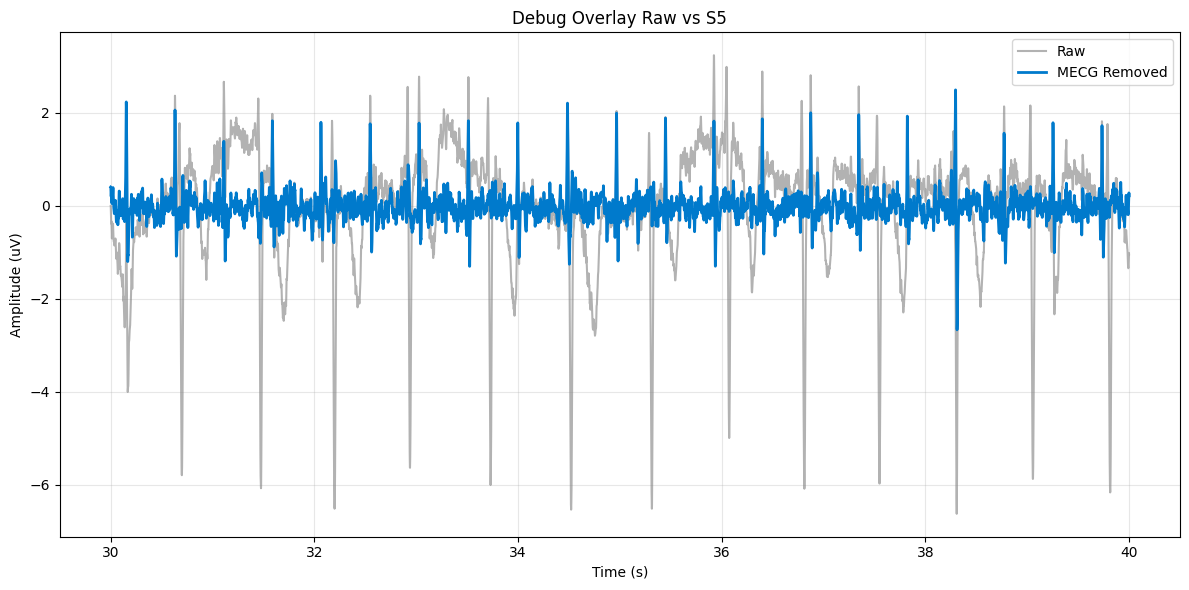

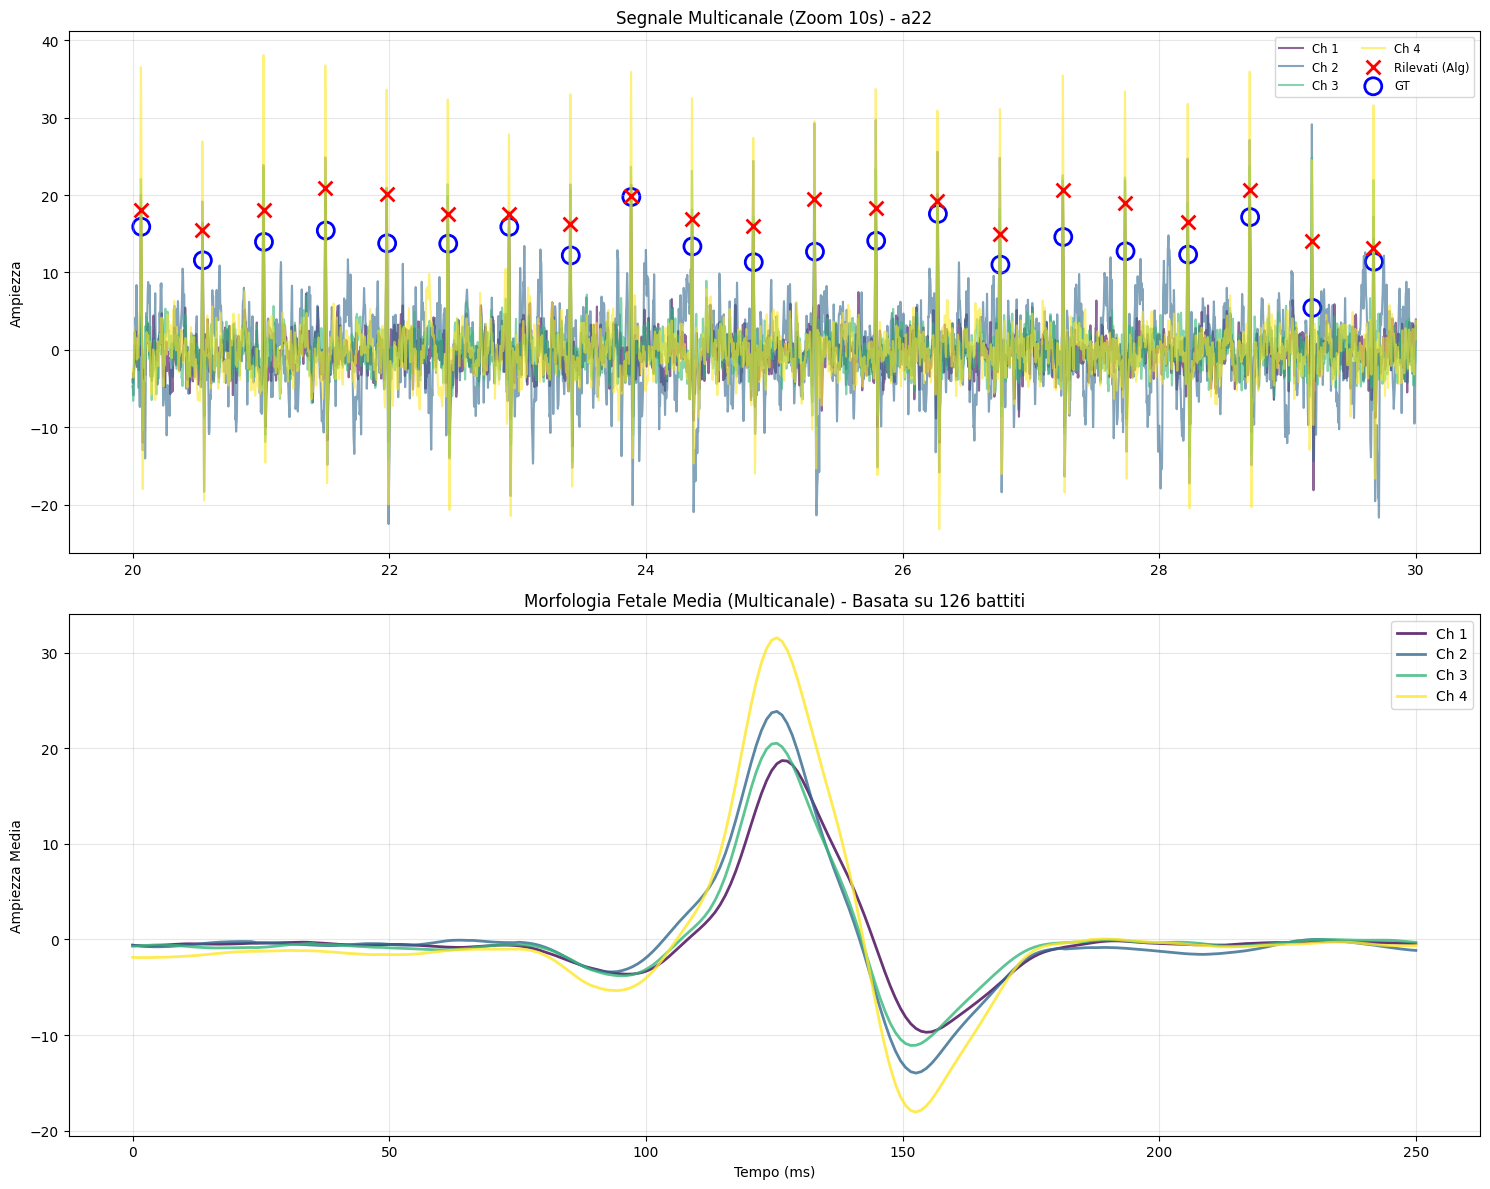

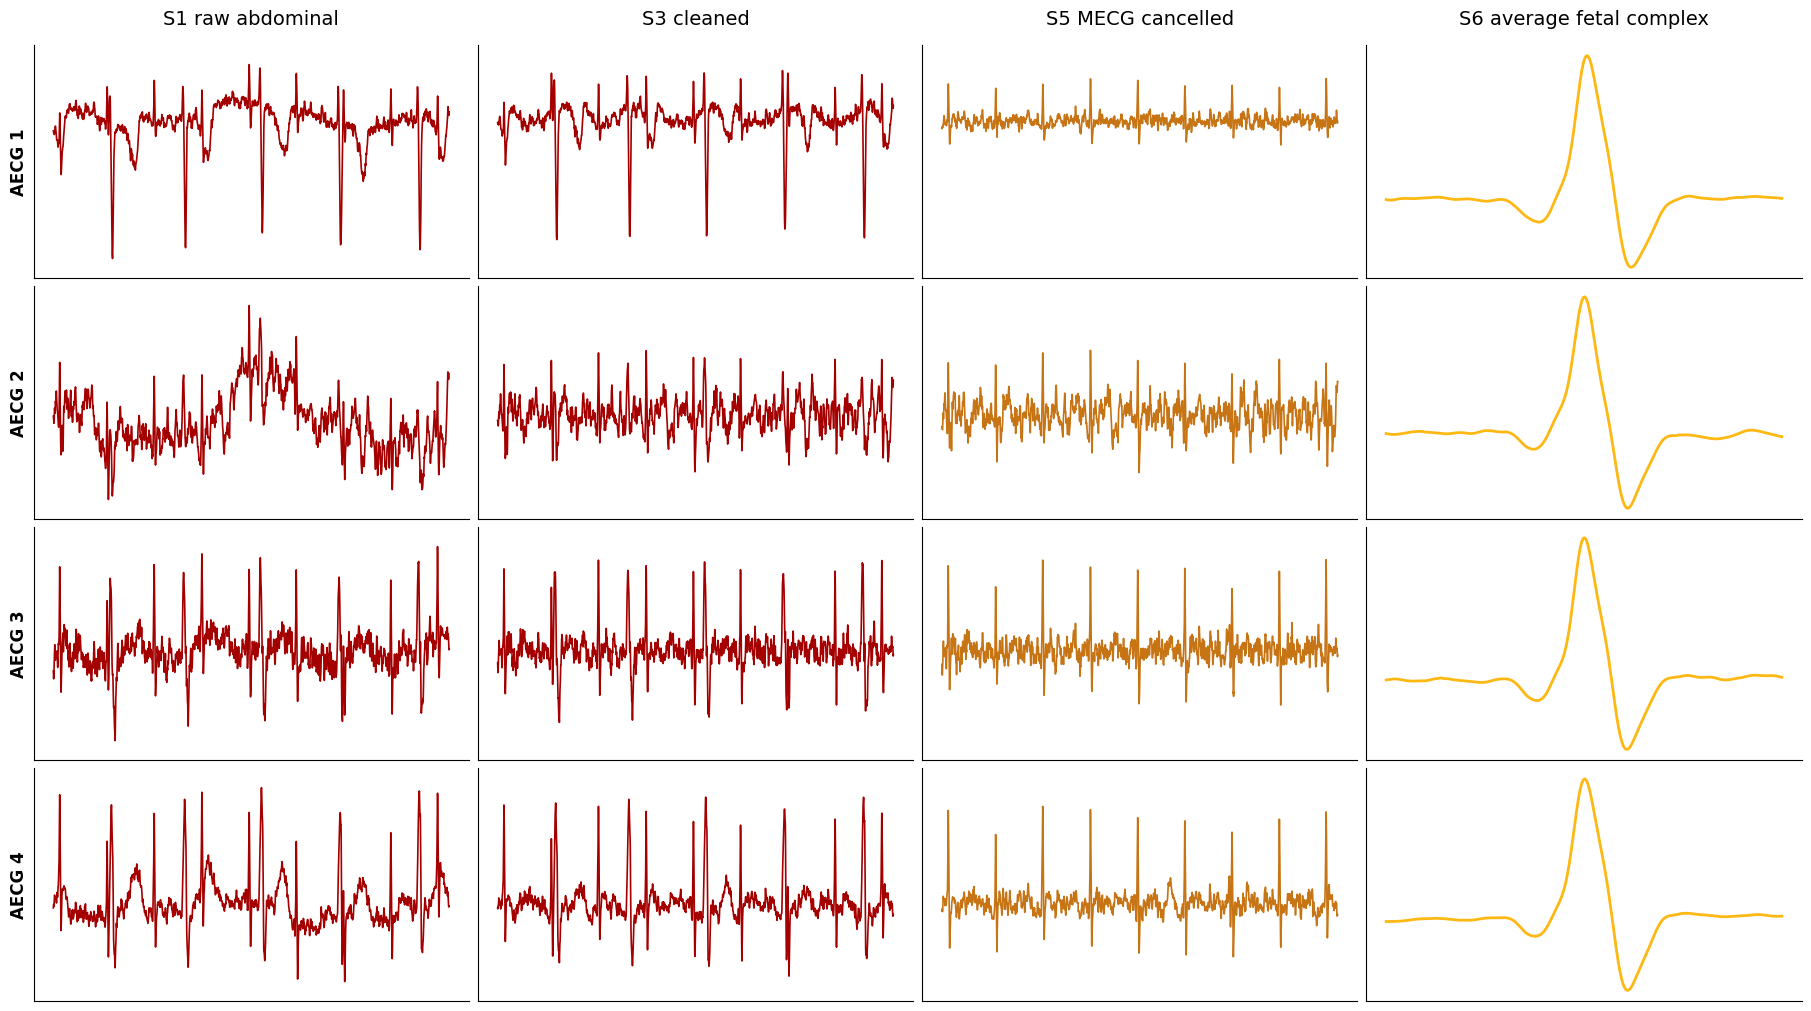

In [2]:
BASE_PATH = './data/set_a/'
record_list = [f"a{i:02d}" for i in range(1, 26)]
TARGET_FS = 2000
OUTPUT_CSV = "risultati_metriche.csv"

header = ['REC', 'BPM', 'Reliability', 'SNR', 'SIR', 'Accuracy', 'Se', 'PPV', 'F1']
with open(OUTPUT_CSV, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

fetal_extractor = FetalECGExtractor(TARGET_FS)

for rec_name in record_list:
    
    full_path = os.path.join(BASE_PATH, rec_name)
    # try:
    raw, fields = load_and_interpolate(full_path)
    fs_native = fields['fs']
    n_samples = raw.shape[0]
    
    # 1. Preprocessing
    # S4 = Cleaned (con madre), S5 = MECG Cancelled (solo feto) - Ipotesi basata sull'uso in SNR
    S5, S4, up_factor = preprocess_signal(raw, fs_native, TARGET_FS)
    
    best_signal, S6, f_peaks = extract_and_analyze_multichannel(S5, fetal_extractor, TARGET_FS)
    
    gt_peaks, _ = load_ground_truth(full_path, n_samples, up_factor)
    
    if rec_name == "a22":
        debug_plot_overlay(raw, fs_native, S5, TARGET_FS, title="Debug Overlay Raw vs S5", start_s=30, duration_s=10, channel_idx=0)
        plot_results(rec_name, S5, f_peaks, gt_peaks, fetal_extractor, TARGET_FS)

        # --- NUOVA CHIAMATA PLOT PIPELINE ---
        from scipy.signal import resample
        
        # 1. Per il plot S1, portiamo 'raw' alla stessa lunghezza degli altri segnali
        # (solo per visualizzazione, non tocca i dati originali)
        if len(raw) != len(S5):
            raw_for_plot = resample(raw, len(S5))
        else:
            raw_for_plot = raw

        # 2. Chiamata alla funzione 4x4
        plot_pipeline_stages(
            s1_raw=raw_for_plot,
            s3_cleaned=S4,
            s5_cancelled=S5,
            s6_avg_beat=S6,
            fs=TARGET_FS,
            start_sec=20,
            duration_sec=4
        )
    
    noise = subtract_average_beat(S5, f_peaks, S6)

    snr, sir = calculate_snr_sir(S4, S5, S6, noise)
    
    seg_len_up = n_samples * up_factor
    rel, bpm, success = calculate_paper_metrics(f_peaks, TARGET_FS, seg_len_up)
    performance = evaluate_performance(gt_peaks, f_peaks, TARGET_FS, tol_ms=50)
    
    with open(OUTPUT_CSV, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            rec_name, 
            f"{bpm:.2f}", 
            f"{rel:.4f}", 
            f"{snr:.2f}", 
            f"{sir:.2f}",
            f"{performance['Accuracy']:.2f}",
            f"{performance['Se']:.2f}",
            f"{performance['PPV']:.2f}",
            f"{performance['F1']:.2f}"
        ])

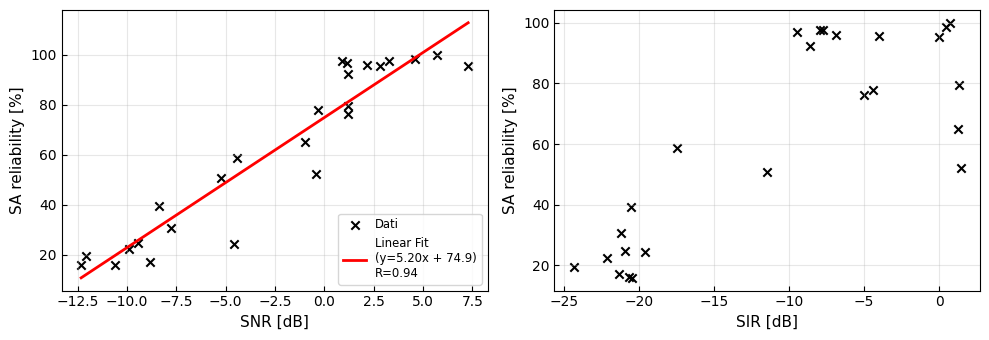

In [3]:
def linear_func(x, m, q):
    return m * x + q

df = pd.read_csv(OUTPUT_CSV)
df['Reliability_Pct'] = df['Reliability'] * 100

df_sorted = df.sort_values(by='SNR')
x_data = df_sorted['SNR'].values
y_data = df_sorted['Reliability_Pct'].values

x_fit = []
y_fit = []
fit_label = "Fit fallito"

# Esecuzione del Fitting
try:
    popt, pcov = curve_fit(linear_func, x_data, y_data)
    
    m, q = popt
    
    # Genera la linea di fit
    x_fit = np.linspace(min(x_data), max(x_data), 500)
    y_fit = linear_func(x_fit, *popt)
    
    # Calcolo coefficiente di correlazione
    correlation_matrix = np.corrcoef(x_data, y_data)
    r_value = correlation_matrix[0, 1]
    
    fit_label = f'Linear Fit\n(y={m:.2f}x + {q:.1f})\nR={r_value:.2f}'
    
except Exception as e:
    print(f"Errore nel fitting: {e}")

# --- 3. Chiamata alla funzione di Plot ---
plot_reliability_correlations(df, x_fit, y_fit, fit_label)

In [4]:
corr_matrix_pearson = df[['Reliability', 'SNR', 'SIR']].corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(corr_matrix_pearson)


Pearson Correlation Matrix:
             Reliability       SNR       SIR
Reliability     1.000000  0.944731  0.816044
SNR             0.944731  1.000000  0.893221
SIR             0.816044  0.893221  1.000000


In [5]:
SNRs = df['SNR'].values
SIRs = df['SIR'].values
print(f"{SNRs.mean():.2f}")
print(f"{SIRs.mean():.2f}")

-2.55
-10.76
